
Credit Card Kaggle- Fixing Imbalanced Dataset
Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from imblearn.under_sampling import NearMiss  #Library for UnderSampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek  #Library for OverSampling
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42


In [2]:
Labels = ["Normal", "Fraud"]

In [3]:
data = pd.read_csv('C:/Data/creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


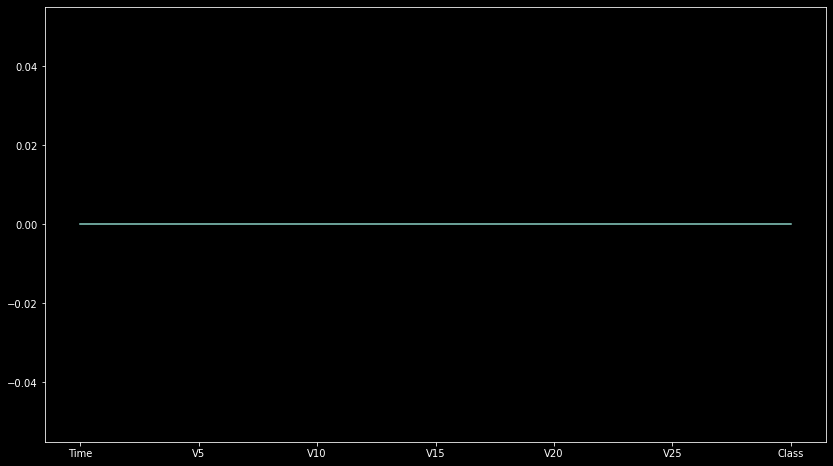

In [4]:
data.isnull().sum().plot()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:

#Create independent and Dependent Features
cols = data.columns.tolist()
# Filter the columns to remove data we do not want 
cols = [i for i in cols if i !=  "Class"]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(30)
X = data[cols]
y = data[target]
# Print the shapes of X & Y
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


Exploratory Data Analysis

Text(0.5, 1.0, 'class Frequency')

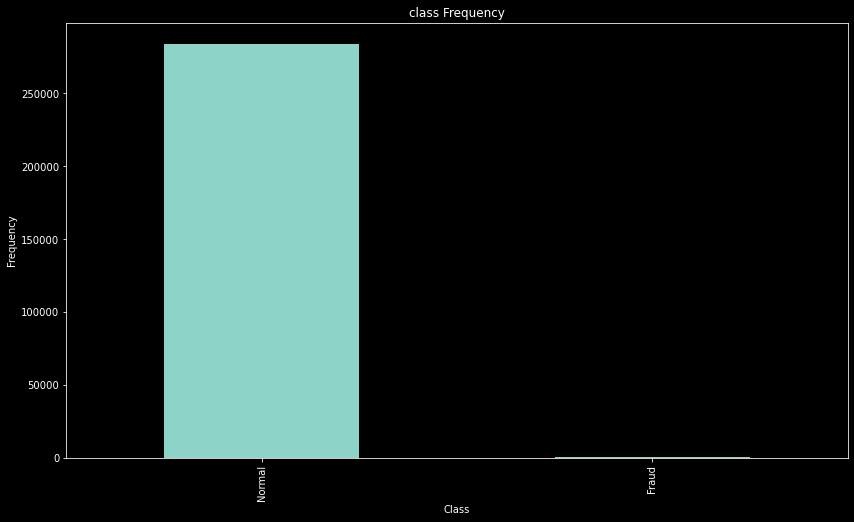

In [7]:
data["Class"].value_counts().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(range(2),Labels)
plt.title( "class Frequency")

In [8]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

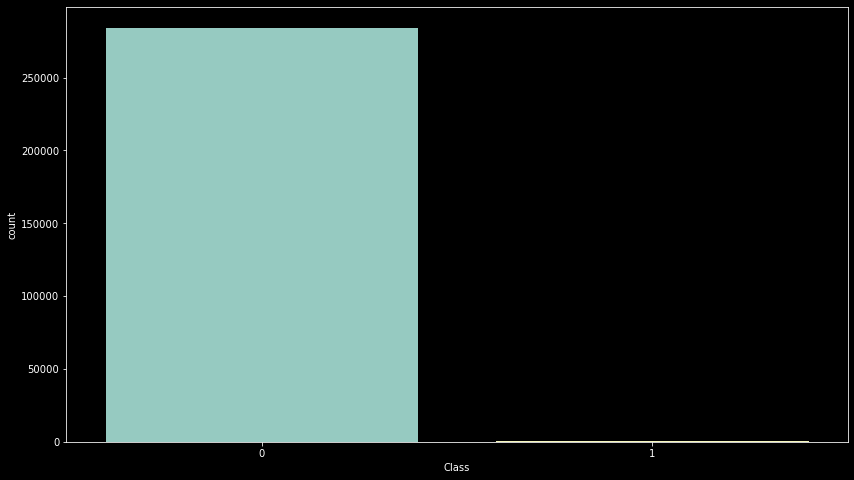

In [9]:
# You can use Count Plot in Seaborn
sns.countplot(data["Class"])

In [10]:
# get fraud and Normal Counts
fraud=data[data["Class"]==1]
Normal=data[data["Class"]==0]

In [11]:
print(f"Normal: {Normal.shape} and Fraud: { fraud.shape}")

Normal: (284315, 31) and Fraud: (492, 31)


Cross Validation (KFOLD) and Hyperparameter tuning

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

In [14]:
10.0 **np.arange(-2,3)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [15]:
log_class=LogisticRegression()
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}
cv=KFold(n_splits=5,random_state=None,shuffle=False)

In [16]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7)

In [17]:

clf=GridSearchCV(log_class,grid,cv=cv,n_jobs=-1,scoring='f1_macro')
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

[[85270    36]
 [   48    89]]
0.9990168884519505
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85306
           1       0.71      0.65      0.68       137

    accuracy                           1.00     85443
   macro avg       0.86      0.82      0.84     85443
weighted avg       1.00      1.00      1.00     85443



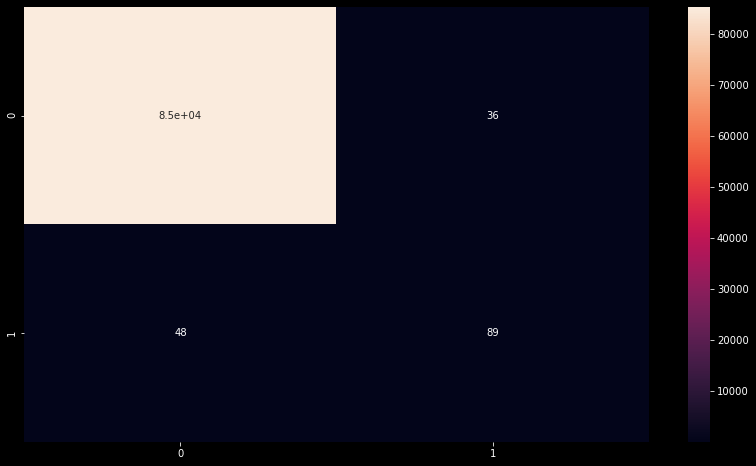

In [20]:
y_pred=clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

Using the Traditional Method of Assigning Weights and Balancing Data

In [23]:
len(fraud)/len(Normal)

0.0017304750013189597

In [24]:
class_weight={0:1,1:100}

In [25]:

from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(class_weight=class_weight)
classifier.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 100})

In [26]:
y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[85300     6]
 [   29   108]]
0.9995903701883126
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85306
           1       0.95      0.79      0.86       137

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Ensemble Techniques

In [27]:
from imblearn.ensemble import EasyEnsembleClassifier

In [28]:
easy=EasyEnsembleClassifier()
easy.fit(X_train,y_train)

EasyEnsembleClassifier()

In [29]:
y_pred=easy.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[82591  2715]
 [   13   124]]
0.9680722821061994
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85306
           1       0.04      0.91      0.08       137

    accuracy                           0.97     85443
   macro avg       0.52      0.94      0.53     85443
weighted avg       1.00      0.97      0.98     85443

